In [5]:
import yfinance as yf
from datetime import datetime
import pytz
import pandas as pd
import pymysql

from dotenv import load_dotenv
import os

import logging
import time


In [6]:
# Load variables from .env
load_dotenv()

# === MySQL config ===

# localhost
db_config_local = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'yahoo_finance'
}

# aivencloud
timeout = 10
db_config = {
    'charset': "utf8mb4",
    'connect_timeout': timeout,
    'cursorclass': pymysql.cursors.DictCursor,
    'db': os.getenv('DB_NAME'),
    'host': os.getenv('DB_HOST'),
    'password': os.getenv('DB_PASSWORD'),
    'port': int(os.getenv('DB_PORT')),
    'user': os.getenv('DB_USER'),
    'write_timeout': timeout,
    'read_timeout': timeout
}

In [ ]:
# === Set up logging ===
logging.basicConfig(filename='data_loader.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', encoding='utf-8')

# === Tickers and Intervals ===
interval = '1m'
period = '8d'
assets = [{'ticker': 'EURUSD=X', 'alias': 'EURUSD', 'interval': interval, 'period': period}, 
          {'ticker': 'SXR8.DE', 'alias': 'iShares Core S&P 500 ETF', 'interval': interval, 'period': period},
          {'ticker': '^GSPC', 'alias': 'S&P 500', 'interval': interval, 'period': period}
         ]

def fetch_data(ticker, period, interval, retries=3):
    for attempt in range(retries):
        try:
            logging.info(f"Fetching {ticker} with {interval} interval for {period} (Attempt {attempt + 1})")
            df = yf.download(ticker, interval=interval, period=period, progress=False)
            if df.empty:
                logging.warning(f"No data returned for {ticker} on attempt {attempt + 1}")
                continue
            df.columns = [col[0] for col in df.columns]  # Flatten MultiIndex
            df.reset_index(inplace=True)
            return df
        except Exception as e:
            logging.warning(f"Attempt {attempt + 1} failed for {ticker}: {e}")
            time.sleep(5)
    logging.error(f"❌ All {retries} attempts failed for {ticker}")
    return pd.DataFrame()

def insert_data(cursor, data, ticker, interval_str):
    cet = pytz.timezone('CET')
    now = datetime.now(cet)
    inserted_rows = 0

    for _, row in data.iterrows():
        timestamp = row['Datetime'] if 'Datetime' in row else row['Date']
        if isinstance(timestamp, pd.Timestamp):
            timestamp = timestamp.to_pydatetime()

        sql = """
            INSERT IGNORE INTO market_data 
            (ticker, interval_type, timestamp, open, high, low, close, volume, loaded_at)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
        """
        values = (
            ticker,
            interval_str,
            timestamp,
            row['Open'],
            row['High'],
            row['Low'],
            row['Close'],
            row.get('Volume', 0),
            now
        )
        try:
            cursor.execute(sql, values)
            inserted_rows += cursor.rowcount
        except Exception as e:
            logging.error(f"Error inserting data for {ticker} at {timestamp}: {e}")
    
    return inserted_rows

In [10]:
try:
    conn = pymysql.connect(**db_config_local)
    cursor = conn.cursor()
    logging.info("✅ Connected using PyMySQL!")

    total_inserted = 0
    success_assets = 0
    
    # === loading data into mysql database ===
    for asset in assets:
        df = fetch_data(asset['ticker'], asset['period'], asset['interval'])
        if not df.empty:
            inserted = insert_data(cursor, df, asset['ticker'], asset['interval'])
            total_inserted += inserted
            success_assets += 1
            logging.info(f"✅ Inserted {inserted} rows for {asset['ticker']}.")
        else:
            logging.warning(f"⚠️ Skipped {asset['ticker']} — no data.")
    
    conn.commit()
    cursor.close()
    conn.close()
    
    if success_assets > 0:
        logging.info(f"✅ Finished: Inserted a total of {total_inserted} rows for {success_assets}/{len(assets)} assets.")
    else:
        logging.warning("⚠️ Finished: No data was inserted for any asset.")

except Exception as e:
    logging.error(f"Error in the main function: {e}")

In [102]:
dfz = pd.DataFrame()
for asset in assets:
    df = fetch_data(asset['ticker'], asset['period'], asset['interval'])
    df['ticker']=asset['ticker']
    dfz = pd.concat([dfz, df], ignore_index=True)
    

Fetching EURUSD=X with 1m interval for 8d
Fetching SXR8.DE with 1m interval for 8d
Fetching ^GSPC with 1m interval for 8d


In [105]:
df1=dfz[dfz.ticker=='SXR8.DE']
df2=dfz[dfz.ticker=='^GSPC']

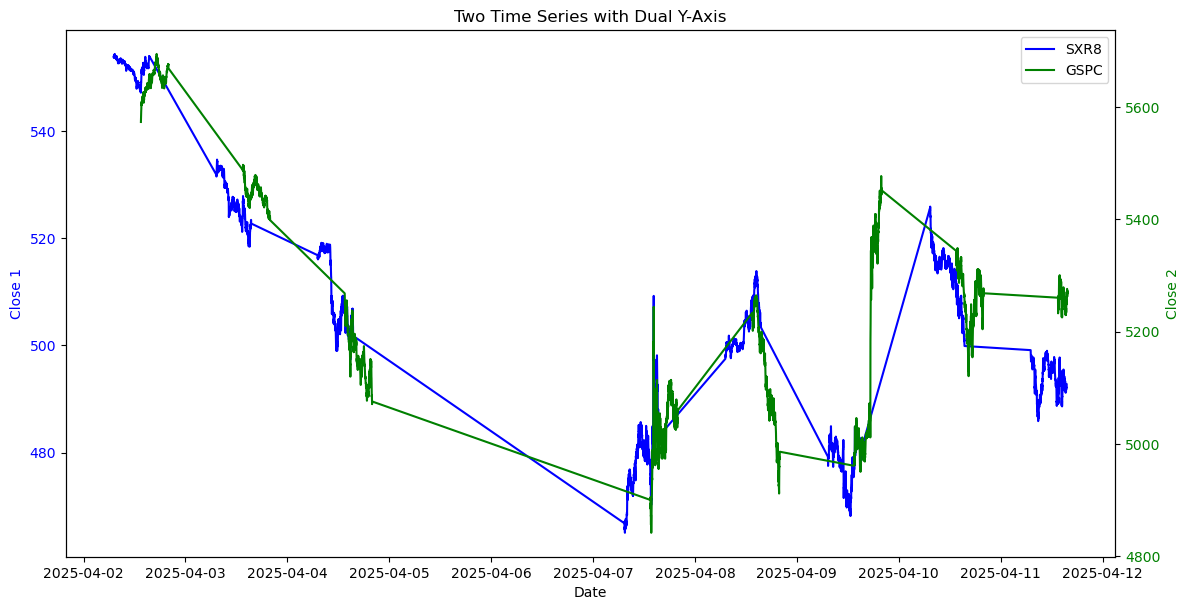

In [108]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df1['Datetime'], df1['Close'], color='blue', label='SXR8')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df2['Datetime'], df2['Close'], color='green', label='GSPC')
ax2.set_ylabel('Close 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

fig.tight_layout()
plt.title("Two Time Series with Dual Y-Axis")
plt.show()

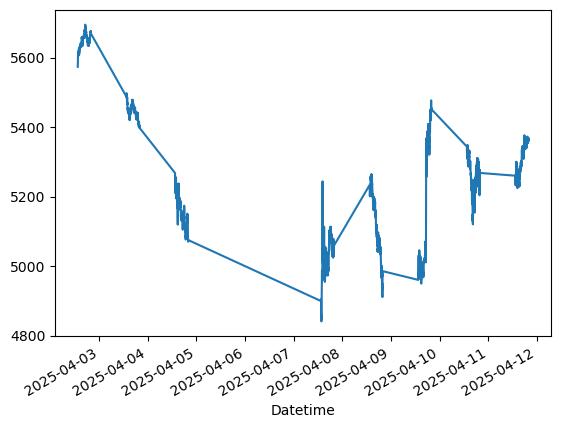

In [107]:
dfz[dfz.ticker=='^GSPC'].set_index('Datetime').Close.plot();

In [8]:
# pd.set_option('display.max_rows', None)
dft = yf.download('EURUSD=X', interval=interval, period=period, progress=False).reset_index()
dft.sort_values('Datetime', ascending=False)

YF.download() has changed argument auto_adjust default to True


Price,Datetime,Close,High,Low,Open,Volume
Ticker,,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
11186,2025-04-11 21:29:00+00:00,1.136364,1.136364,1.136364,1.136364,0
11185,2025-04-11 21:28:00+00:00,1.136364,1.136364,1.136364,1.136364,0
11184,2025-04-11 21:27:00+00:00,1.136364,1.136364,1.136364,1.136364,0
11183,2025-04-11 21:26:00+00:00,1.136364,1.136364,1.136364,1.136364,0
11182,2025-04-11 21:25:00+00:00,1.136364,1.136364,1.136364,1.136364,0
...,...,...,...,...,...,...
4,2025-04-01 23:04:00+00:00,1.080030,1.080030,1.080030,1.080030,0
3,2025-04-01 23:03:00+00:00,1.080030,1.080030,1.080030,1.080030,0
2,2025-04-01 23:02:00+00:00,1.080030,1.080030,1.080030,1.080030,0


In [10]:
dft.columns = [col[0] for col in dft.columns]  # Extract first level ('Close', 'Open', etc.)


In [13]:
type(dft.iloc[0].Datetime)
isinstance(dft.iloc[0].Datetime, pd.Timestamp)

dft.iloc[-1].Datetime.to_pydatetime()


datetime.datetime(2025, 4, 11, 21, 29, tzinfo=datetime.timezone.utc)